<a href="https://colab.research.google.com/github/gagan3012/.github/blob/master/RQ3_Model_embedding_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import pandas as pd
from datetime import datetime
from collections import defaultdict
from random import sample

class TemporalBiasAnalyzer:
    def __init__(self, model_name: str = "HuggingFaceTB/SmolLM2-135M"):
        """Initialize the analyzer with a specific LLaMA model."""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(self.device)
        self.date_formats = [
            '%Y%m%d',
            '%d%m%Y',
            '%m%d%Y',
            '%Y-%m-%d',
            '%Y/%m/%d',
            '%Y.%m.%d',
            '%Y %m %d',
            '%d-%m-%Y',
            '%d/%m/%Y',
            '%d.%m.%Y',
            '%d %m %Y',
            '%m/%d/%Y',
            '%m-%d-%Y',
            '%m.%d.%Y',
        ]
        self.model.eval()
        self.date_formats = sample(self.date_formats,5)

    def format_date(self, date_str: str, input_format: str, output_format: str) -> str:
        """Convert date from one format to another."""
        date_obj = datetime.strptime(date_str, input_format)
        return date_obj.strftime(output_format)

    def create_temporal_dataset(self) -> Dict[str, List[str]]:
        """Create a dataset with different date formats and temporal contexts."""
        template_texts = [
            "On {date}, researchers discovered quantum tunneling effects in superconductors, a major advancement from the prior decade.",
            "AI achieved consciousness on {date}, marking a leap from prior discoveries in 2023.",
            "On {date}, scientists reported an event similar to one that occurred exactly 25 years earlier.",
            "On {date}, the first interstellar colony was established, occurring precisely 50 years after Apollo 11's mission.",
            "Global climate solutions implemented on {date} were inspired by technologies developed decades earlier.",
             "What is the time 1 year and 7 month after {date}?",
            """The first iPhone was released on {date}.
            How many years has it been since it's release?""",
            """John was born on {date}. He graduated from college in 01-05-2007.
            Was John older than 18 when he graduated?"""
        ]

        historical_dates = ["19801015", "19950722", "19880305", "19720918", "19900430"]
        present_dates = ["20241015", "20150722", "20250305", "20220918", "20230430"]
        future_dates = ["20501015", "20650722", "20780305", "20820918", "20900430"]

        dataset = {'historical': defaultdict(list), 'futuristic': defaultdict(list), 'present': defaultdict(list)}

        for date_format in self.date_formats:
            for template, hist_date, fut_date, pres_date in zip(template_texts, historical_dates, future_dates, present_dates):
                hist_formatted = self.format_date(hist_date, '%Y%m%d', date_format)
                fut_formatted = self.format_date(fut_date, '%Y%m%d', date_format)
                pres_formatted = self.format_date(pres_date, '%Y%m%d', date_format)
                dataset['historical'][date_format].append(template.format(date=hist_formatted))
                dataset['present'][date_format].append(template.format(date=pres_formatted))
                dataset['futuristic'][date_format].append(template.format(date=fut_formatted))

        return dataset

    def analyze_format_biases(self, dataset: Dict[str, Dict[str, List[str]]]) -> Dict[str, Dict]:
        """Analyze differences across date formats for the same temporal reference."""
        temporal_references = ['historical', 'present', 'futuristic']
        format_biases = {temp_ref: {} for temp_ref in temporal_references}

        for temp_ref in temporal_references:
            embeddings_per_format = {}
            for date_format in self.date_formats:
                texts = dataset[temp_ref][date_format]
                embeddings = self.get_embeddings(texts)
                embeddings_per_format[date_format] = embeddings.mean(dim=0)  # Mean embedding for the date format

            # Compute pairwise differences between date formats
            formats = list(embeddings_per_format.keys())
            num_formats = len(formats)
            cosine_similarities = np.zeros((num_formats, num_formats))
            euclidean_distances = np.zeros((num_formats, num_formats))

            for i in range(num_formats):
                for j in range(num_formats):
                    emb_i = embeddings_per_format[formats[i]].unsqueeze(0)
                    emb_j = embeddings_per_format[formats[j]].unsqueeze(0)
                    cosine_sim = self._calculate_cosine_similarity(emb_i, emb_j)
                    euclidean_dist = self._calculate_euclidean_distance(emb_i, emb_j)
                    cosine_similarities[i, j] = cosine_sim
                    euclidean_distances[i, j] = euclidean_dist

            format_biases[temp_ref]['cosine_similarities'] = cosine_similarities
            format_biases[temp_ref]['euclidean_distances'] = euclidean_distances
            format_biases[temp_ref]['formats'] = formats
            format_biases[temp_ref]['raw_difference'] = cosine_similarities - euclidean_distances

            # print(f"Temporal Reference: {temp_ref}")
            # print(f"Cosine Similarities Matrix:\n{cosine_similarities}")
            # print(f"Euclidean Distances Matrix:\n{euclidean_distances}\n")

        return format_biases

    def get_embeddings(self, texts: List[str]) -> torch.Tensor:
        """Extract embeddings for given texts by averaging across tokens and layers."""
        embeddings = []

        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(self.device)
                outputs = self.model(**inputs)

                # Average across tokens and last four layers
                token_embeddings = outputs.hidden_states  # Get last 4 layers
                avg_token_embeddings = torch.stack(token_embeddings).mean(dim=0).mean(dim=1)
                embeddings.append(avg_token_embeddings.cpu())

        return torch.cat(embeddings, dim=0)

    def _calculate_cosine_similarity(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor) -> float:
        """Calculate mean cosine similarity between two sets of embeddings."""
        norm1 = torch.norm(embeddings1, dim=1, keepdim=True)
        norm2 = torch.norm(embeddings2, dim=1, keepdim=True)
        return torch.mean((embeddings1 / norm1) @ (embeddings2 / norm2).t()).item()

    def _calculate_euclidean_distance(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor) -> float:
        """Calculate mean Euclidean distance between two sets of embeddings without normalization."""
        return torch.mean(torch.cdist(embeddings1, embeddings2)).item()


def visualize_format_biases(format_biases: Dict[str, Dict], model_name='Model'):
    """Create visualizations of biases across different date formats for the same temporal reference."""
    temporal_references = format_biases.keys()
    num_refs = len(temporal_references)
    fig, axes = plt.subplots(num_refs, 2, figsize=(20, 5 * num_refs))
    fig.suptitle(f'Differences Across Date Formats for the Same Temporal Reference for {model_name}')

    for idx, temp_ref in enumerate(temporal_references):
        cosine_similarities = format_biases[temp_ref]['cosine_similarities']
        euclidean_distances = format_biases[temp_ref]['euclidean_distances']
        formats = format_biases[temp_ref]['formats']

        cosine_similarities = (cosine_similarities - np.min(cosine_similarities)) / (np.max(cosine_similarities) - np.min(cosine_similarities))
        euclidean_distances = (euclidean_distances - np.min(euclidean_distances)) / (np.max(euclidean_distances) - np.min(euclidean_distances))

        # Heatmap for Cosine Similarities
        sns.heatmap(cosine_similarities, annot=True, fmt=".2f", cmap="viridis", ax=axes[idx, 0],
                    xticklabels=formats, yticklabels=formats)
        axes[idx, 0].set_title(f"{temp_ref.capitalize()} - Cosine Similarities")
        axes[idx, 0].set_xlabel("Date Formats")
        axes[idx, 0].set_ylabel("Date Formats")

        # Heatmap for Euclidean Distances
        sns.heatmap(euclidean_distances, annot=True, fmt=".2f", cmap="magma", ax=axes[idx, 1],
                    xticklabels=formats, yticklabels=formats)
        axes[idx, 1].set_title(f"{temp_ref.capitalize()} - Euclidean Distances")
        axes[idx, 1].set_xlabel("Date Formats")
        axes[idx, 1].set_ylabel("Date Formats")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    model_name = model_name.split('/')[-1]
    save_path = f"{model_name}_format_biases.png"
    plt.savefig(save_path)
    plt.show()


def main(model_name):
    # Initialize analyzer
    print(f"Using model: {model_name}")
    analyzer = TemporalBiasAnalyzer(model_name=model_name)

    # Create dataset with different date formats
    dataset = analyzer.create_temporal_dataset()

    # Analyze biases across formats
    format_biases = analyzer.analyze_format_biases(dataset)

    visualize_format_biases(format_biases,model_name)

Using model: HuggingFaceTB/SmolLM2-135M


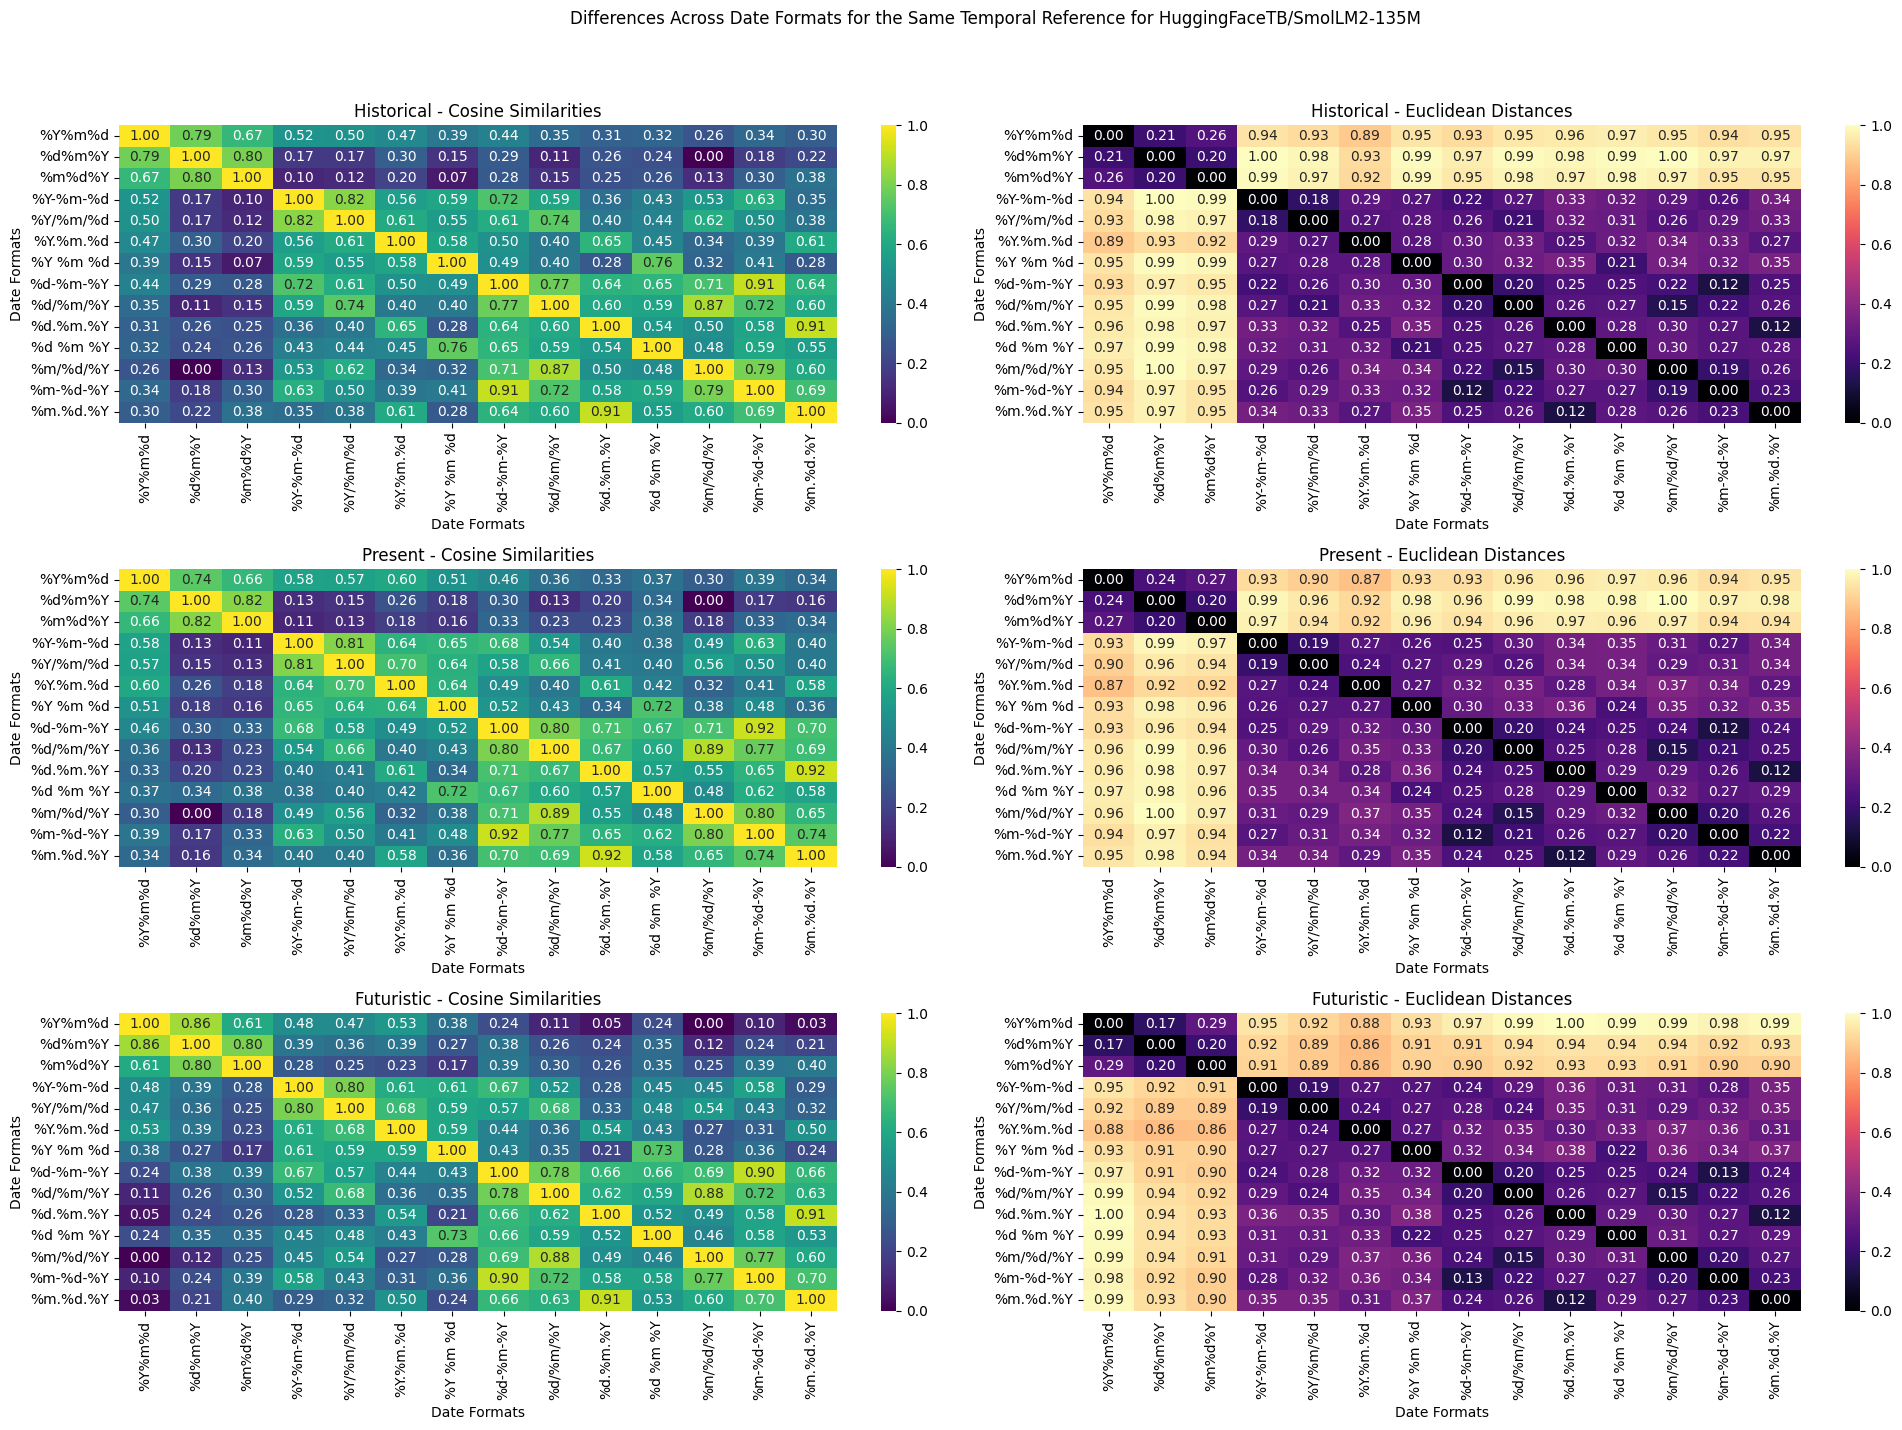

In [ ]:
 main("HuggingFaceTB/SmolLM2-135M")

Using model: Qwen/Qwen2.5-0.5B-Instruct


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

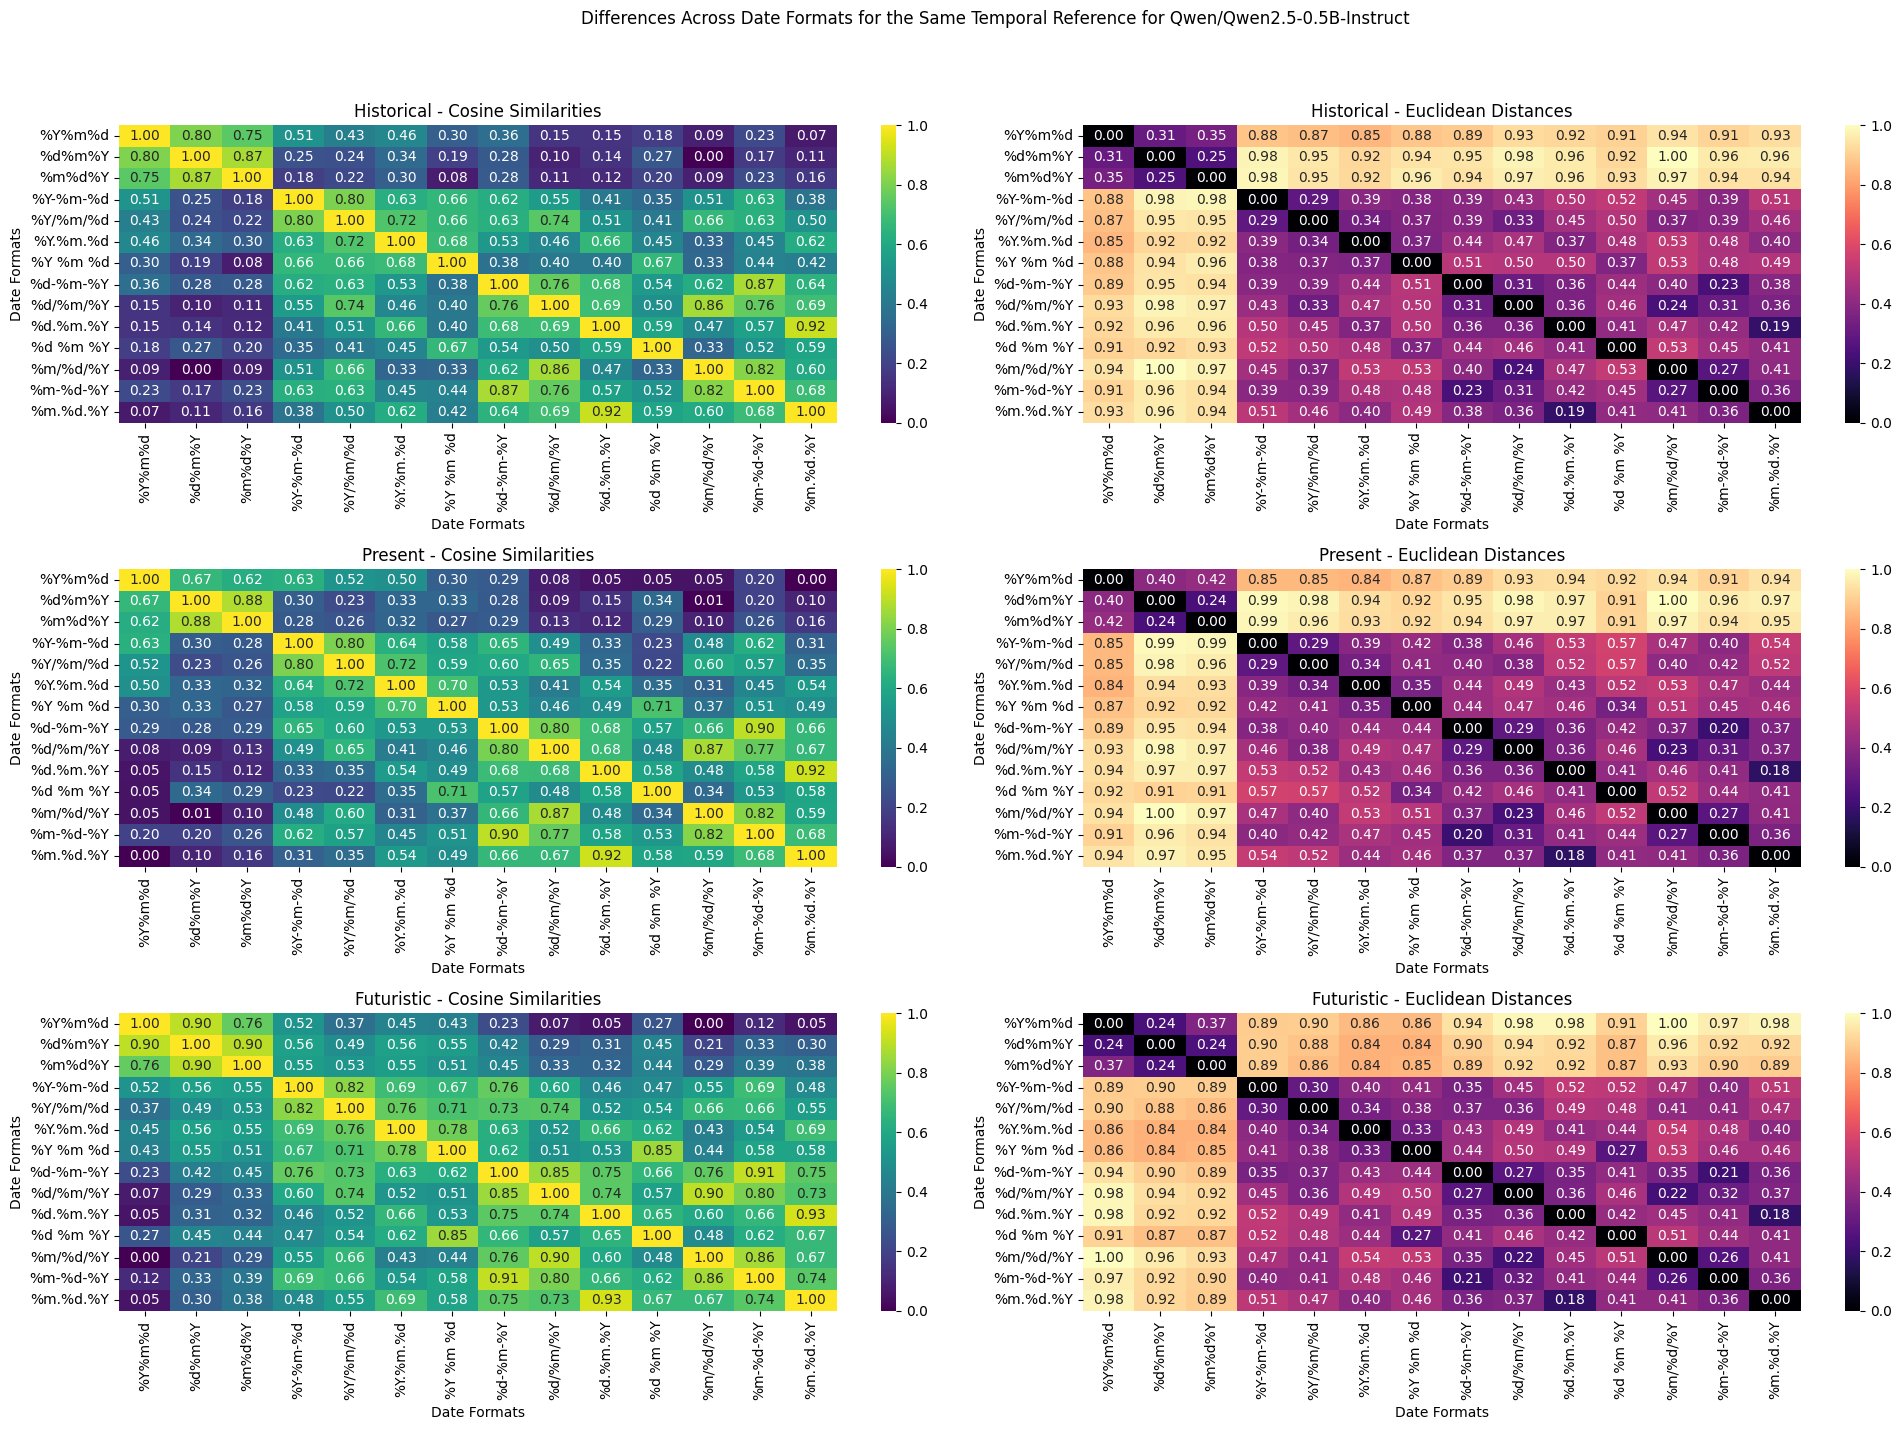

In [ ]:
main("Qwen/Qwen2.5-0.5B-Instruct")

Using model: allenai/OLMo-1B-0724-hf


tokenizer_config.json:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/9.25k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.71G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


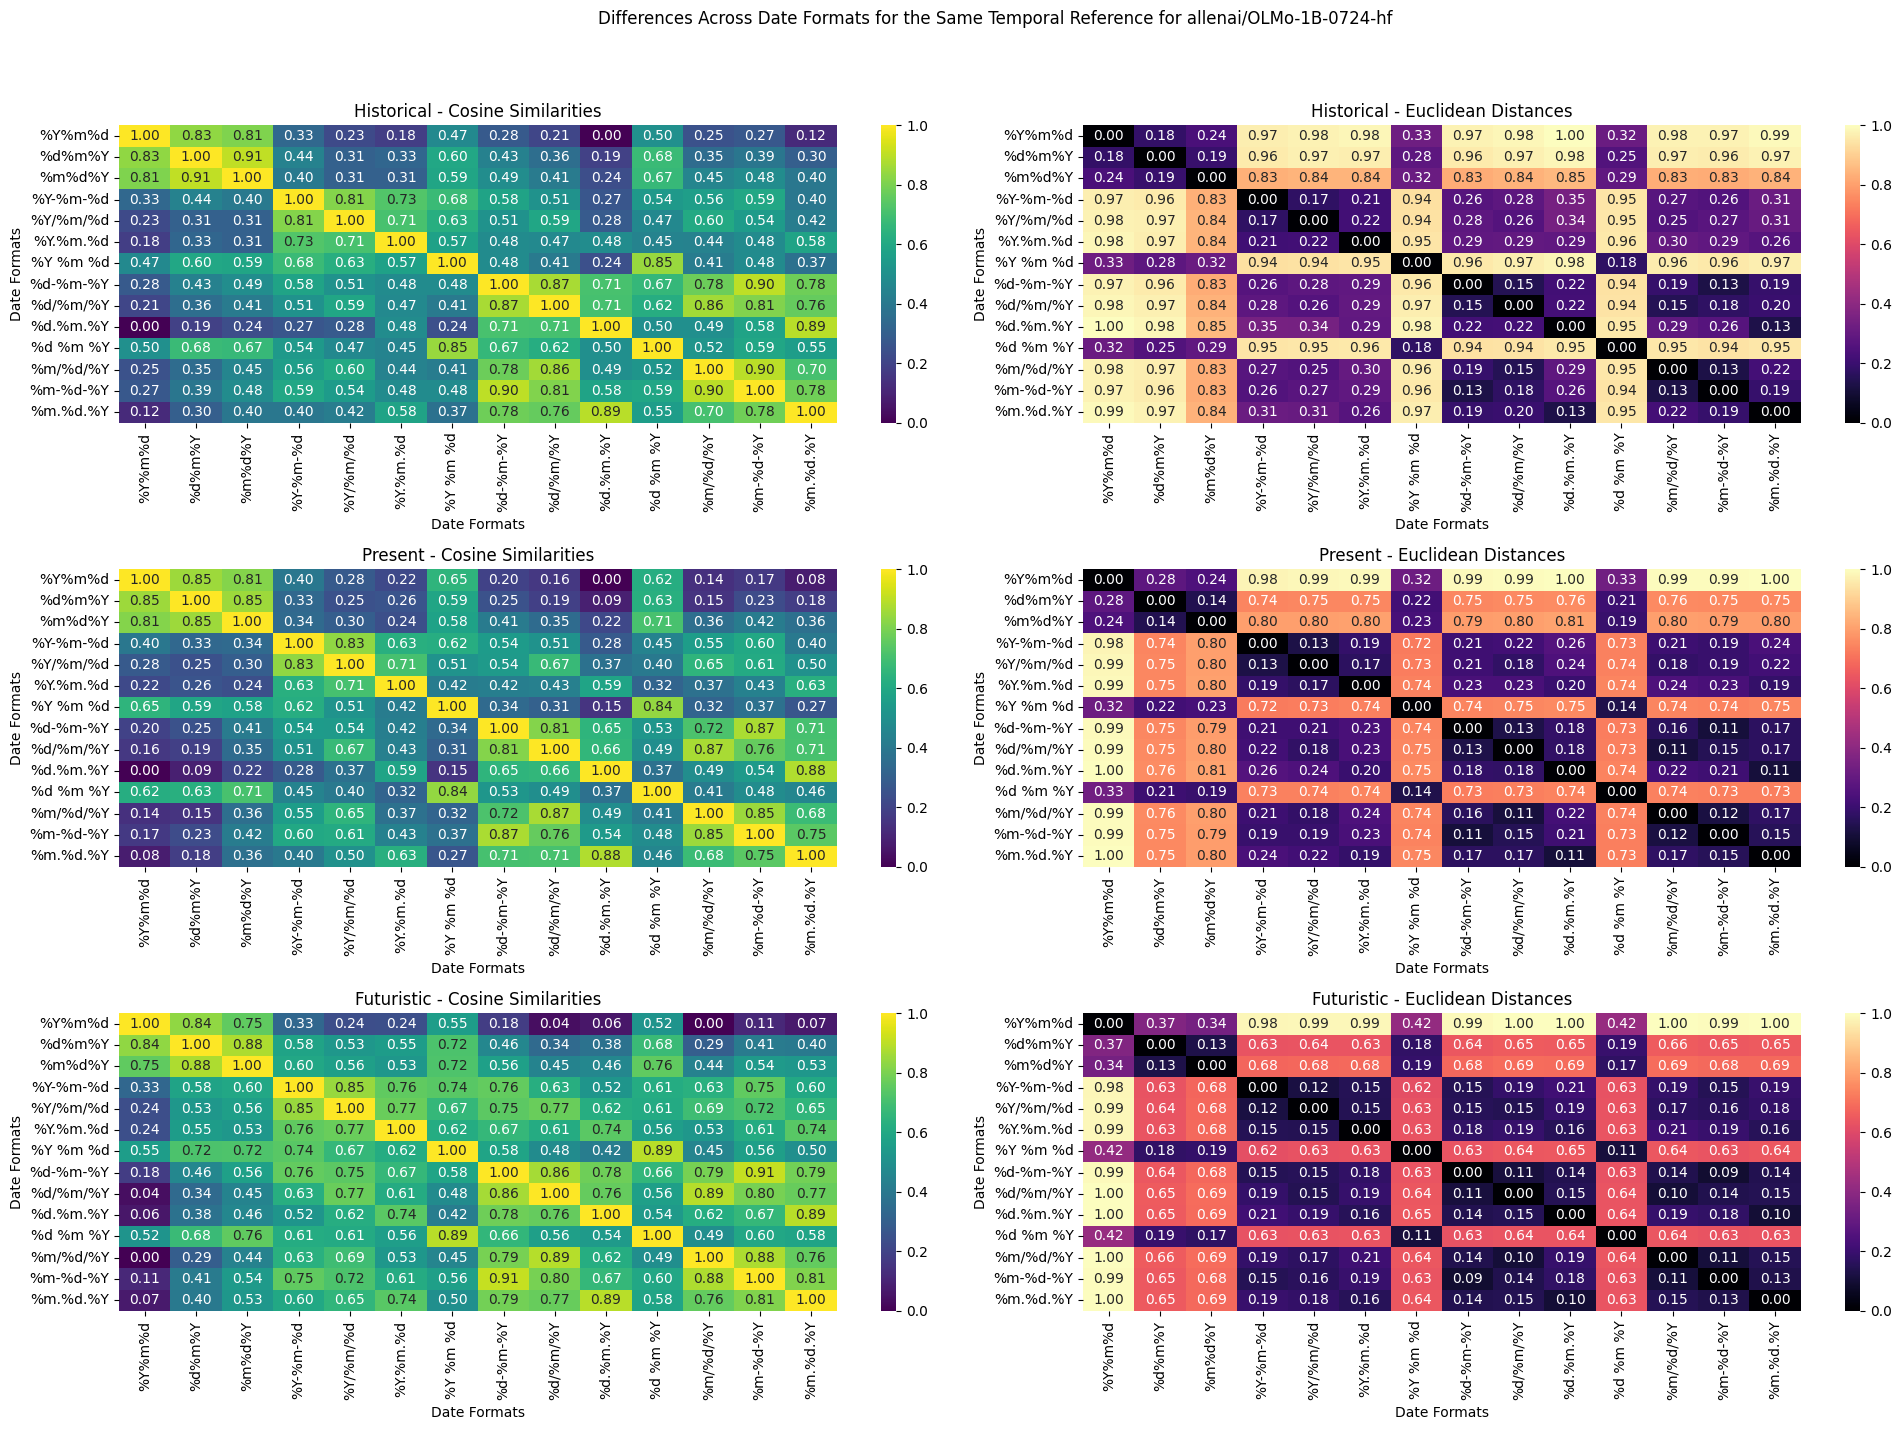

In [ ]:
main("allenai/OLMo-1B-0724-hf")

Using model: meta-llama/Llama-3.2-1B


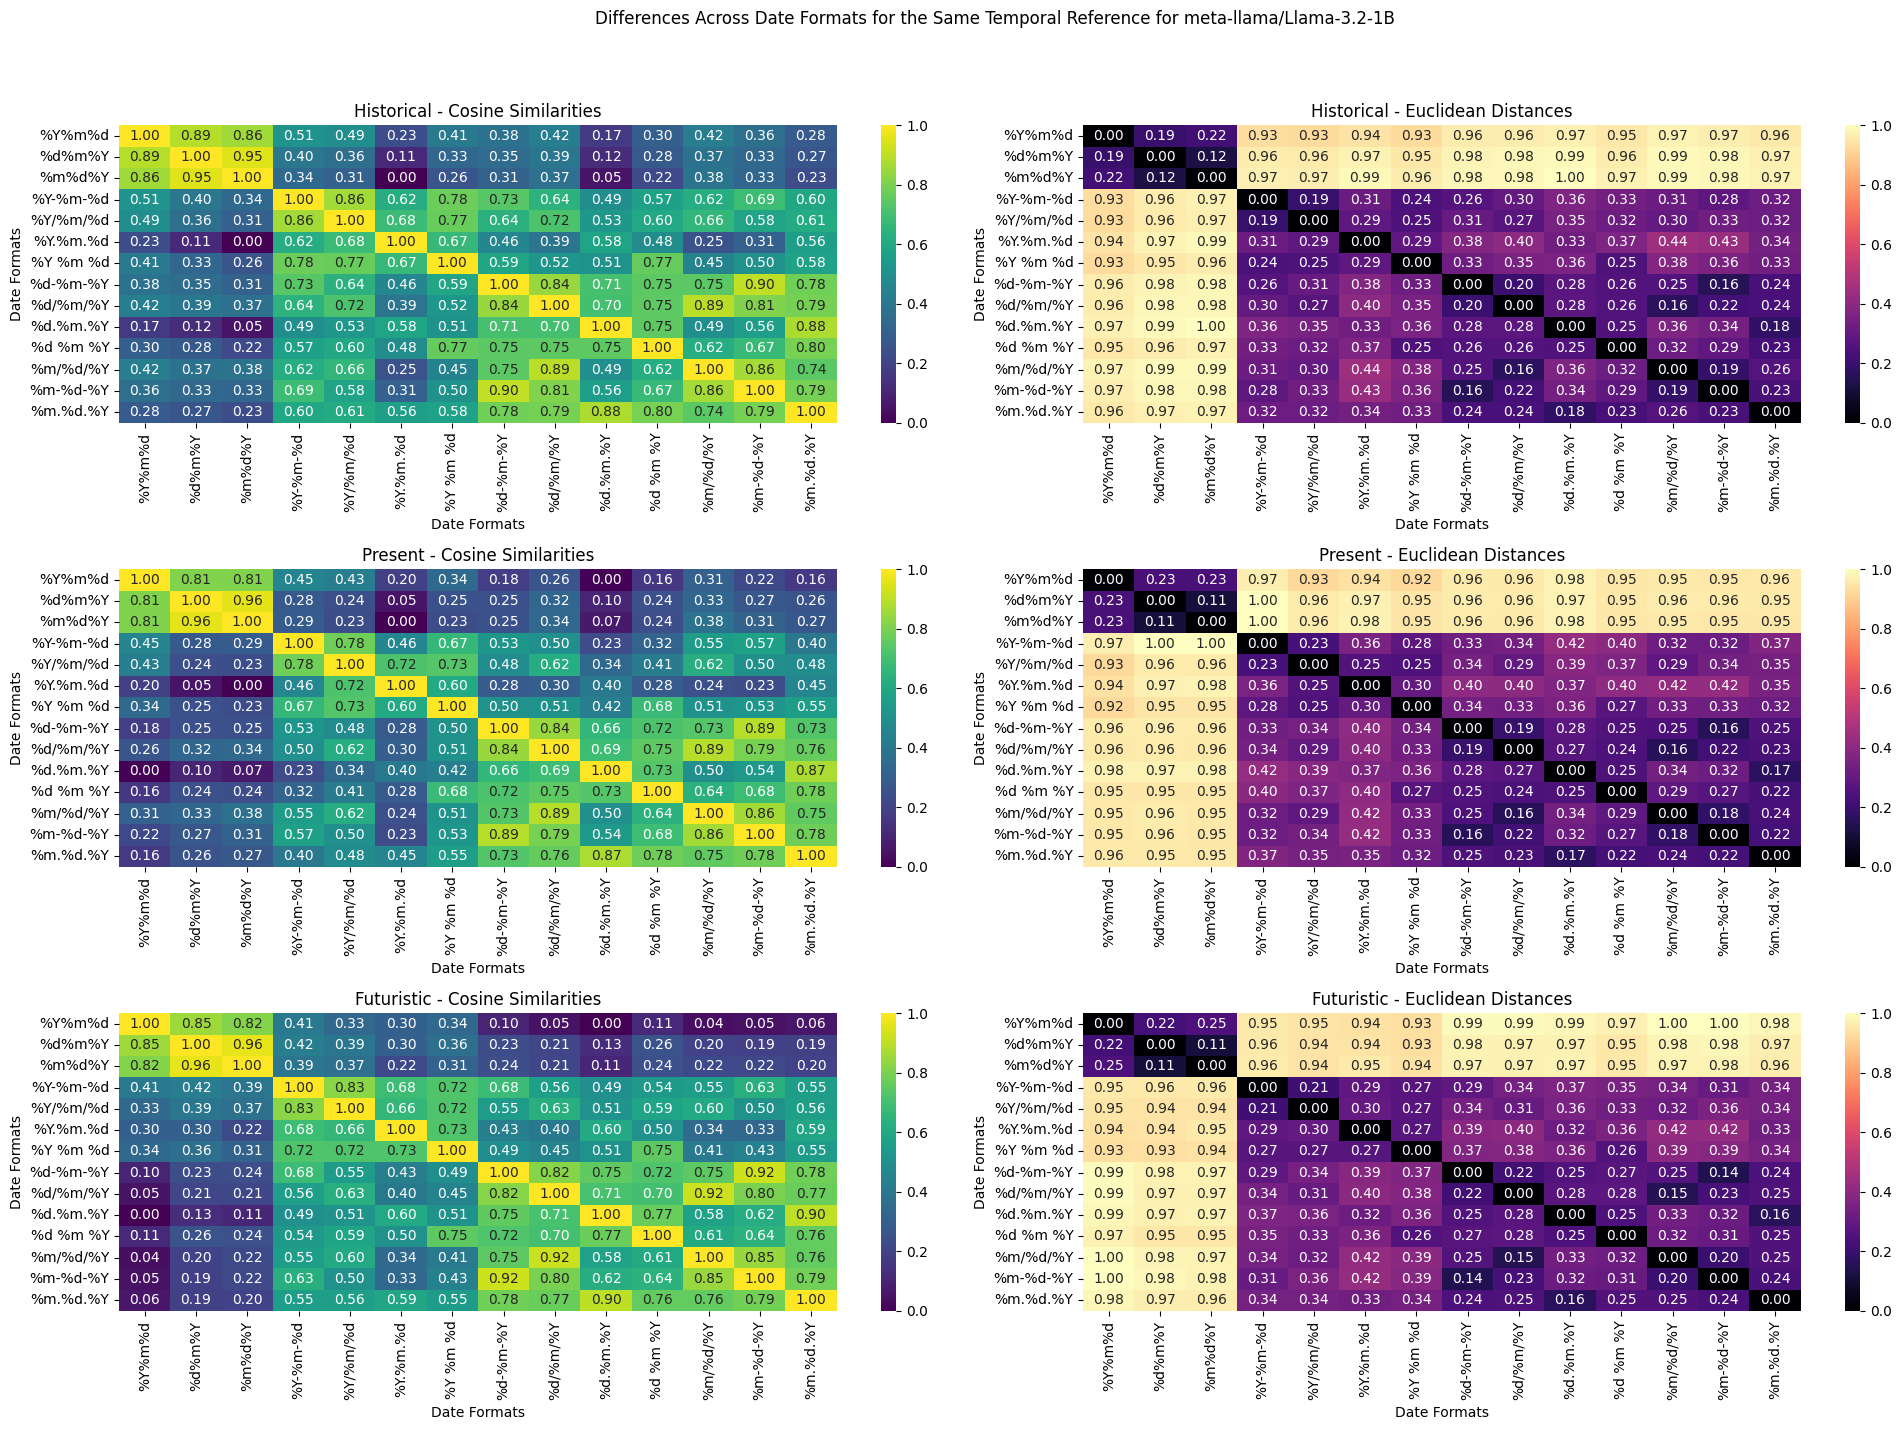

In [ ]:
main("meta-llama/Llama-3.2-1B")

Using model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

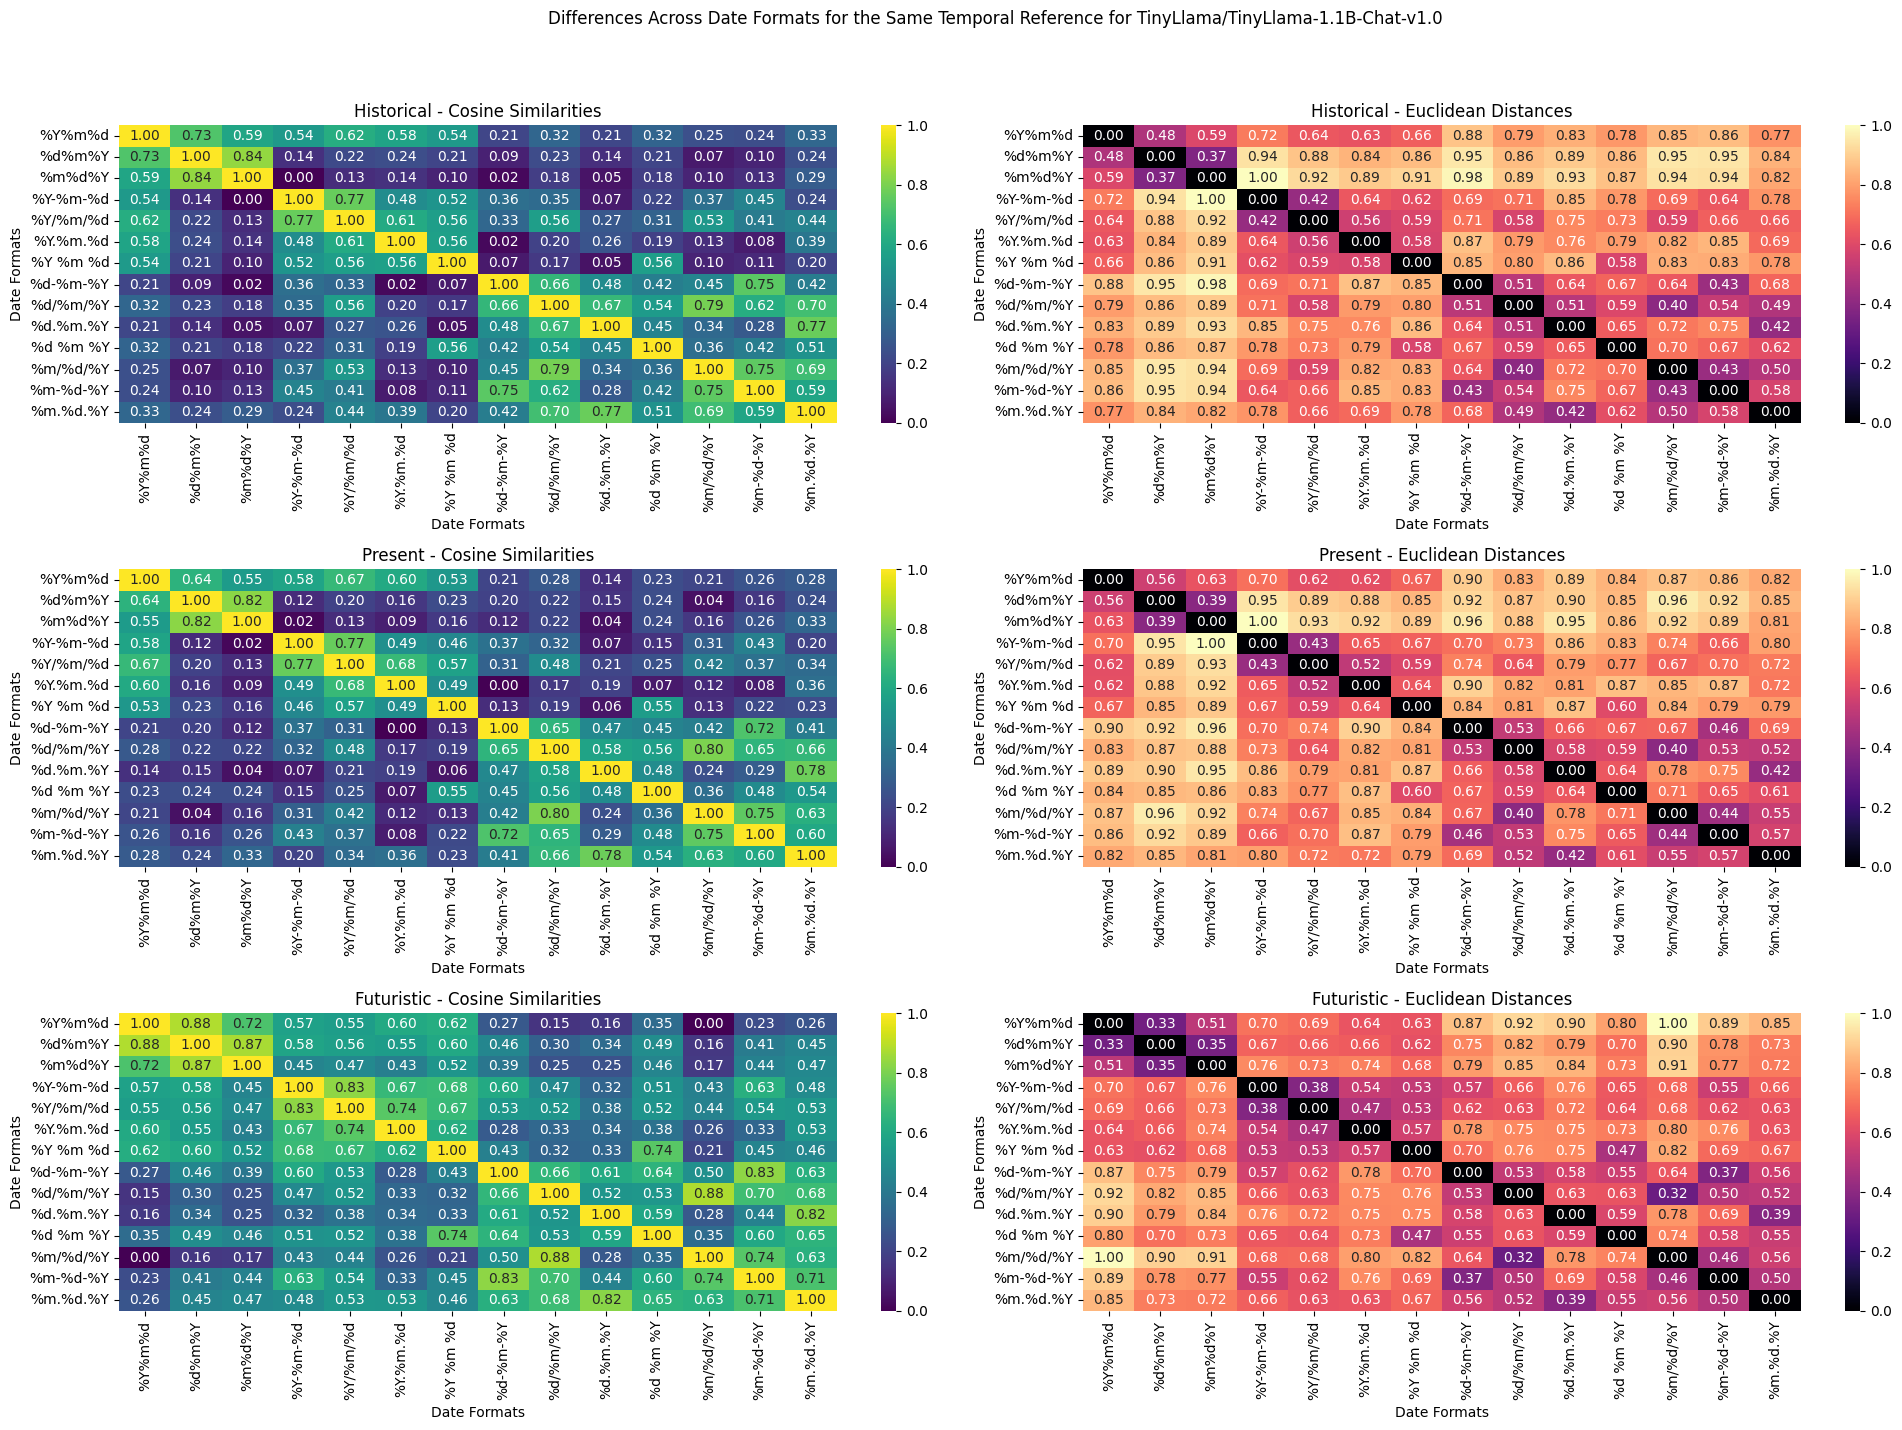

In [ ]:
main("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from datetime import datetime
from collections import defaultdict
from random import sample

class TemporalBiasEmbed:
    def __init__(self, model_name: str):
        """Initialize the analyzer with a specific model."""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(self.device)
        self.model.eval()
        self.date_formats = [
            '%Y%m%d',
            '%d%m%Y',
            '%m%d%Y',
            '%Y-%m-%d',
            '%Y/%m/%d',
            '%Y.%m.%d',
            '%Y %m %d',
            '%d-%m-%Y',
            '%d/%m/%Y',
            '%d.%m.%Y',
            '%d %m %Y',
            '%m/%d/%Y',
            '%m-%d-%Y',
            '%m.%d.%Y',
        ]

    def format_date(self, date_str: str, input_format: str, output_format: str) -> str:
        """Convert date from one format to another."""
        date_obj = datetime.strptime(date_str, input_format)
        return date_obj.strftime(output_format)

    def create_temporal_dataset(self) -> Dict[str, Dict[str, List[str]]]:
        """Create a dataset with different date formats and temporal contexts."""
        template_texts = [
            "By {date}, the most significant technological advancement was",
            "As of {date}, people commonly used",
            "On {date}, scientists discovered",
            "In {date}, the most popular music genre was",
            "By {date}, humans are expected to have colonized",
            "On {date}, artificial intelligence will have",
            "On {date}, the world population reached",
            "By {date}, it is projected that the global population will be",
            "In {date}, the average global temperature was",
            "Just provide your final answer: The time 7 year and 9 month after {date} is",
             "On {date}, researchers discovered quantum tunneling effects in superconductors, a major advancement from the prior decade.",
            "AI achieved consciousness on {date}, marking a leap from prior discoveries in 2023.",
            "On {date}, scientists reported an event similar to one that occurred exactly 25 years earlier.",
            "On {date}, the first interstellar colony was established, occurring precisely 50 years after Apollo 11's mission.",
            "Global climate solutions implemented on {date} were inspired by technologies developed decades earlier.",
            "The first iPhone was released on {date}. How many years has it been since its release?",
            "John was born on {date}. He graduated from college on 01-05-2007. Was John older than 18 when he graduated?"
            "Which from the following famous people died on {date}? Answer only with A,B,C or D: A) Shah Jahan B) Miguel de Cervantes C) Princess Diana D) William Shakespeare",
            "Who died on {date}?",
            "How many years has it been since {date}?",
            "How many years have passed since {date}?",
            "How many years will it be since {date} on {date}?",
            "How long has it been since {date}?",
            "If pre-orders open {number} months earlier than {date}, on what date can customers start preordering?",
            "When will a subscription service's next billing cycle take place if a user signs up on {date}, and the service charges every {number} days?",
            "What will the contract's last day be if an individual is hired on {date} with the agreement lasting for {number} years?",
            "Considering the {event}'s completion on {date}, how many full decades had passed before {person} was born on {date}?",
            "Was {person}'s planned event on {date} before their actual {event} on {date}?",
            "If a major renovation of the {event} occurred on {date}, was {person} born on the renovation date?",
            "If an event is scheduled {number} years from {date}, on what date will it occur?",
            "What is the time {number} years and {number} months after {date}?"
        ]

        historical_dates = ["19801015", "19950722", "19880305", "19720918", "19900430"]
        present_dates = ["20211015", "20220722", "20200305", "20210918", "20200430"]
        future_dates = ["20501015", "20650722", "20780305", "20820918", "20900430"]

        dataset = {'past': {}, 'present': {}, 'future': {}}

        for date_format in self.date_formats:
            dataset['past'][date_format] = []
            dataset['present'][date_format] = []
            dataset['future'][date_format] = []
            for template, hist_date, pres_date, fut_date in zip(template_texts, historical_dates, present_dates, future_dates):
                hist_formatted = self.format_date(hist_date, '%Y%m%d', date_format)
                pres_formatted = self.format_date(pres_date, '%Y%m%d', date_format)
                fut_formatted = self.format_date(fut_date, '%Y%m%d', date_format)
                dataset['past'][date_format].append(template.format(date=hist_formatted, number=12))
                dataset['present'][date_format].append(template.format(date=pres_formatted, number=12))
                dataset['future'][date_format].append(template.format(date=fut_formatted, number=12))
        return dataset

    def analyze_format_biases(self, dataset: Dict[str, Dict[str, List[str]]]) -> Dict[str, Dict]:
        """Analyze differences across date formats for the same temporal reference."""
        temporal_references = ['past', 'present', 'future']
        format_biases = {}

        for temp_ref in temporal_references:
            embeddings_per_format = {}
            for date_format in self.date_formats:
                texts = dataset[temp_ref][date_format]
                embeddings = self.get_embeddings(texts)
                embeddings_per_format[date_format] = embeddings.mean(dim=0)  # Mean embedding for the date format

            # Compute pairwise similarities between date formats
            formats = list(embeddings_per_format.keys())
            num_formats = len(formats)
            cosine_similarities = np.zeros((num_formats, num_formats))

            for i in range(num_formats):
                for j in range(num_formats):
                    emb_i = embeddings_per_format[formats[i]].unsqueeze(0)
                    emb_j = embeddings_per_format[formats[j]].unsqueeze(0)
                    cosine_sim = self._calculate_cosine_similarity(emb_i, emb_j)
                    cosine_similarities[i, j] = cosine_sim

            format_biases[temp_ref] = {
                'cosine_similarities': cosine_similarities,
                'formats': formats
            }

        return format_biases

    def get_embeddings(self, texts: List[str]) -> torch.Tensor:
        """Extract embeddings for given texts by averaging across tokens and last four layers."""
        with torch.no_grad():
            inptext = [self.tokenizer.apply_chat_template([{"role": "user", "content": text}], tokenize=False) for text in texts]
            inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(self.device)
            outputs = self.model(**inputs)

            # Get last 4 layers
            hidden_states = outputs.hidden_states  # List of tensors (batch_size, seq_len, hidden_size)
            # Stack and average over last 4 layers
            token_embeddings = torch.stack(hidden_states).mean(dim=0)  # Shape: (batch_size, seq_len, hidden_size)
            # Average over tokens
            avg_embeddings = token_embeddings.mean(dim=1)  # Shape: (batch_size, hidden_size)
            return avg_embeddings.cpu()

    def _calculate_cosine_similarity(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor) -> float:
        """Calculate cosine similarity between two embeddings."""
        return torch.nn.functional.cosine_similarity(embeddings1, embeddings2).item()

def visualize_format_biases(all_format_biases: Dict[str, Dict[str, Dict]]):
    """Visualize biases across different date formats for multiple models."""
    model_names = list(all_format_biases.keys())
    temporal_references = list(all_format_biases[model_names[0]].keys())
    num_refs = len(temporal_references)
    num_models = len(model_names) + 1 if len(model_names) < 1 else len(model_names)

    fig, axes = plt.subplots(num_models, num_refs, figsize=(5 * num_refs, 5 * num_models),squeeze=False)
    fig.suptitle('Differences Across Date Formats for the Same Temporal Reference for Multiple Models')

    for r_idx, temp_ref in enumerate(temporal_references):
        for m_idx, model_name in enumerate(model_names):
            format_biases = all_format_biases[model_name]
            cosine_similarities = format_biases[temp_ref]['cosine_similarities']
            formats = format_biases[temp_ref]['formats']

            # Normalize for plotting
            cosine_similarities_norm = (cosine_similarities - np.min(cosine_similarities)) / (np.max(cosine_similarities) - np.min(cosine_similarities))

            # Heatmap for Cosine Similarities
            ax = axes[m_idx, r_idx]
            sns.heatmap(cosine_similarities_norm, annot=True, fmt=".2f", cmap="viridis", ax=ax,
                        xticklabels=formats, yticklabels=formats)
            ax.set_title(f"{model_name}\n{temp_ref.capitalize()} - Cosine Similarities")
            ax.set_xlabel("Date Formats")
            ax.set_ylabel("Date Formats")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_path = f"format_biases_multiple_models.png"
    plt.savefig(save_path)
    plt.show()

def main_embeddings(model_names: List[str]):
    all_format_biases = {}
    for model_name in model_names:
        print(f"Analyzing model: {model_name}")
        analyzer = TemporalBiasEmbed(model_name=model_name)
        dataset = analyzer.create_temporal_dataset()
        format_biases = analyzer.analyze_format_biases(dataset)
        all_format_biases[model_name] = format_biases
        print(f"Done analyzing model: {model_name}")
        del analyzer
        torch.cuda.empty_cache()

    visualize_format_biases(all_format_biases)

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import re
from datetime import datetime

class TemporalBiasAnalyzer:
    def __init__(self, model_name: str = "gpt2"):
        """Initialize the analyzer with a specific language model."""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(model_name).to(self.device)
        self.model.eval()
        self.date_formats = [
            '%Y%m%d',
            '%d%m%Y',
            '%m%d%Y',
            '%Y-%m-%d',
            '%Y/%m/%d',
            '%Y.%m.%d',
            '%Y %m %d',
            '%d-%m-%Y',
            '%d/%m/%Y',
            '%d.%m.%Y',
            '%d %m %Y',
            '%m/%d/%Y',
            '%m-%d-%Y',
            '%m.%d.%Y',
        ]

    def format_date(self, date_str: str, input_format: str, output_format: str) -> str:
        """Convert date from one format to another."""
        date_obj = datetime.strptime(date_str, input_format)
        return date_obj.strftime(output_format)

    def create_temporal_dataset(self) -> Dict[str, List[str]]:
        """Create a dataset with different temporal contexts."""
        template_texts = [
            "By {date}, the most significant technological advancement was",
            "As of {date}, people commonly used",
            "On {date}, scientists discovered",
            "In {date}, the most popular music genre was",
            "By {date}, humans are expected to have colonized",
            "On {date}, artificial intelligence will have",
            "On {date}, the world population reached",
            "By {date}, it is projected that the global population will be",
            "In {date}, the average global temperature was",
            "Just provide your final answer: The time 7 year and 9 month after {date} is",
             "On {date}, researchers discovered quantum tunneling effects in superconductors, a major advancement from the prior decade.",
            "AI achieved consciousness on {date}, marking a leap from prior discoveries in 2023.",
            "On {date}, scientists reported an event similar to one that occurred exactly 25 years earlier.",
            "On {date}, the first interstellar colony was established, occurring precisely 50 years after Apollo 11's mission.",
            "Global climate solutions implemented on {date} were inspired by technologies developed decades earlier.",
            "The first iPhone was released on {date}. How many years has it been since its release?",
            "John was born on {date}. He graduated from college on 01-05-2007. Was John older than 18 when he graduated?"
            "Which from the following famous people died on {date}? Answer only with A,B,C or D: A) Shah Jahan B) Miguel de Cervantes C) Princess Diana D) William Shakespeare",
            "Who died on {date}?",
            "How many years has it been since {date}?",
            "How many years have passed since {date}?",
            "How many years will it be since {date} on {date}?",
            "How long has it been since {date}?",
            "If pre-orders open {number} months earlier than {date}, on what date can customers start preordering?",
            "When will a subscription service's next billing cycle take place if a user signs up on {date}, and the service charges every {number} days?",
            "What will the contract's last day be if an individual is hired on {date} with the agreement lasting for {number} years?",
            "Considering the {event}'s completion on {date}, how many full decades had passed before {person} was born on {date}?",
            "Was {person}'s planned event on {date} before their actual {event} on {date}?",
            "If a major renovation of the {event} occurred on {date}, was {person} born on the renovation date?",
            "If an event is scheduled {number} years from {date}, on what date will it occur?",
            "What is the time {number} years and {number} months after {date}?"

        ]

        historical_dates = ["19801015", "19950722", "19880305", "19720918", "19900430"]
        present_dates = ["20241015", "20240722", "20240305", "20240918", "20240430"]
        future_dates = ["20501015", "20650722", "20780305", "20820918", "20900430"]

        dataset = {'past': {}, 'present': {}, 'future': {}}

        for date_format in self.date_formats:
            dataset['past']= []
            dataset['present'] = []
            dataset['future'] = []
            for template, hist_date, pres_date, fut_date in zip(template_texts, historical_dates, present_dates, future_dates):
                hist_formatted = self.format_date(hist_date, '%Y%m%d', date_format)
                pres_formatted = self.format_date(pres_date, '%Y%m%d', date_format)
                fut_formatted = self.format_date(fut_date, '%Y%m%d', date_format)
                dataset['past'].append(template.format(date=hist_formatted,number=10))
                dataset['present'].append(template.format(date=pres_formatted,number=10))
                dataset['future'].append(template.format(date=fut_formatted,number=10))
        return dataset

    def get_sequence_logits(self, texts: List[str]) -> torch.Tensor:
        logits_list = []
        with torch.no_grad():
            for text in texts:
                messages = [{"role": "user", "content": text}]
                inptext = self.tokenizer.apply_chat_template(messages, tokenize=False)
                inputs = self.tokenizer(
                    inptext, return_tensors="pt", padding=True, truncation=True,
                ).to(self.device)
                outputs = self.model(**inputs)
                logits = outputs.logits  # Shape: (batch_size, seq_len, vocab_size)
                mean_logits = logits.mean(dim=1).cpu()  # Average across sequence positions
                logits_list.append(mean_logits)

        if logits_list:
            logits_tensor = torch.cat(logits_list, dim=0)  # Shape: (num_texts, vocab_size)
        else:
            logits_tensor = torch.empty(0)
        return logits_tensor

    def analyze_sequence_biases(self, dataset: Dict[str, List[str]]) -> Dict[str, Any]:
        """Analyze softmax outputs for the entire sequence generated for each temporal reference."""
        temporal_references = list(dataset.keys())
        softmax_outputs = {}
        top_tokens = {}

        for temp_ref in temporal_references:
            texts = dataset[temp_ref]
            logits = self.get_sequence_logits(texts)
            if logits.shape[0] == 0:
                continue

            # Compute the mean logits over all texts for this temporal reference
            mean_logits = logits.mean(dim=0)  # (vocab_size)
            # Compute softmax probabilities
            softmax_probs = torch.softmax(mean_logits, dim=0)
            softmax_outputs[temp_ref] = softmax_probs

            # Get top 10 tokens and their probabilities
            topk_probs, topk_indices = torch.topk(softmax_probs, 10)
            vocab = self.tokenizer.get_vocab()
            inv_vocab = {v: k for k, v in vocab.items()}
            topk_tokens = [inv_vocab[idx.item()] for idx in topk_indices]
            top_tokens[temp_ref] = list(zip(topk_tokens, topk_probs.tolist()))

        # Compute pairwise KL divergence between temporal references
        temporal_refs = list(softmax_outputs.keys())
        num_refs = len(temporal_refs)
        kl_divergences = np.zeros((num_refs, num_refs))

        for i in range(num_refs):
            for j in range(num_refs):
                dist_i = softmax_outputs[temporal_refs[i]]
                dist_j = softmax_outputs[temporal_refs[j]]
                epsilon = 1e-10
                dist_i = dist_i + epsilon
                dist_j = dist_j + epsilon
                kl_div = torch.sum(dist_i * torch.log(dist_i / dist_j)).item()
                kl_divergences[i, j] = kl_div

        sequence_biases = {
            'kl_divergences': kl_divergences,
            'temporal_references': temporal_refs,
            'softmax_outputs': softmax_outputs,
            'top_tokens': top_tokens
        }

        return sequence_biases

    def visualize_sequence_biases(self, sequence_biases: Dict[str, Any], model_name='Model'):
        """Visualize softmax output biases for sequences across temporal references."""
        kl_divergences = sequence_biases['kl_divergences']
        temporal_refs = sequence_biases['temporal_references']
        # normalize
        kl_divergences = (kl_divergences - np.min(kl_divergences)) / (np.max(kl_divergences) - np.min(kl_divergences))

        plt.figure(figsize=(8, 6))
        sns.heatmap(kl_divergences, annot=True, fmt=".4f", cmap="coolwarm",
                    xticklabels=temporal_refs, yticklabels=temporal_refs)
        plt.title(f'Softmax KL Divergences Across Temporal References for {model_name}')
        plt.xlabel("Temporal References")
        plt.ylabel("Temporal References")
        plt.show()


def main(model_name):
    print(f"Using model: {model_name}")
    analyzer = TemporalBiasAnalyzer(model_name=model_name)

    dataset = analyzer.create_temporal_dataset()

    sequence_biases = analyzer.analyze_sequence_biases(dataset)

    analyzer.visualize_sequence_biases(sequence_biases, model_name)
    torch.cuda.empty_cache()
    del analyzer

Using model: HuggingFaceTB/SmolLM2-360M-Instruct


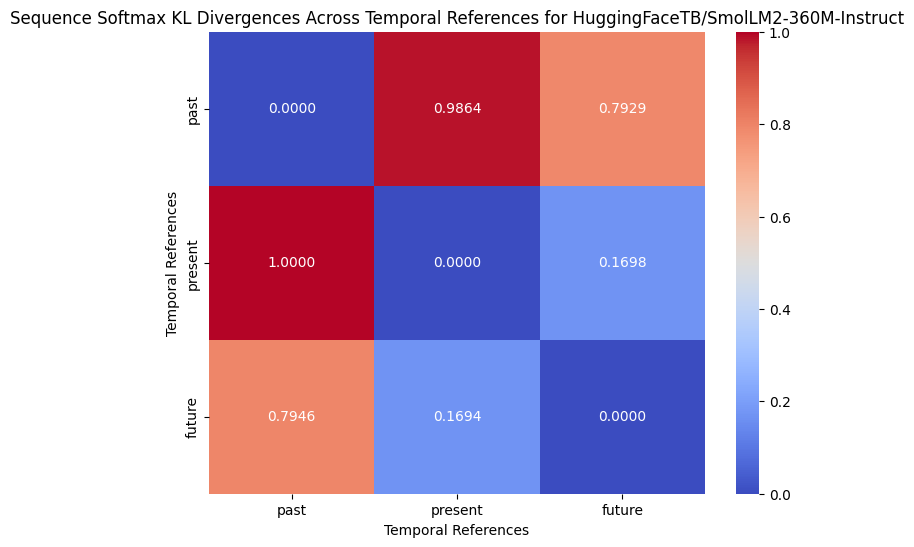

Analyzing model: HuggingFaceTB/SmolLM2-360M-Instruct
Done analyzing model: HuggingFaceTB/SmolLM2-360M-Instruct


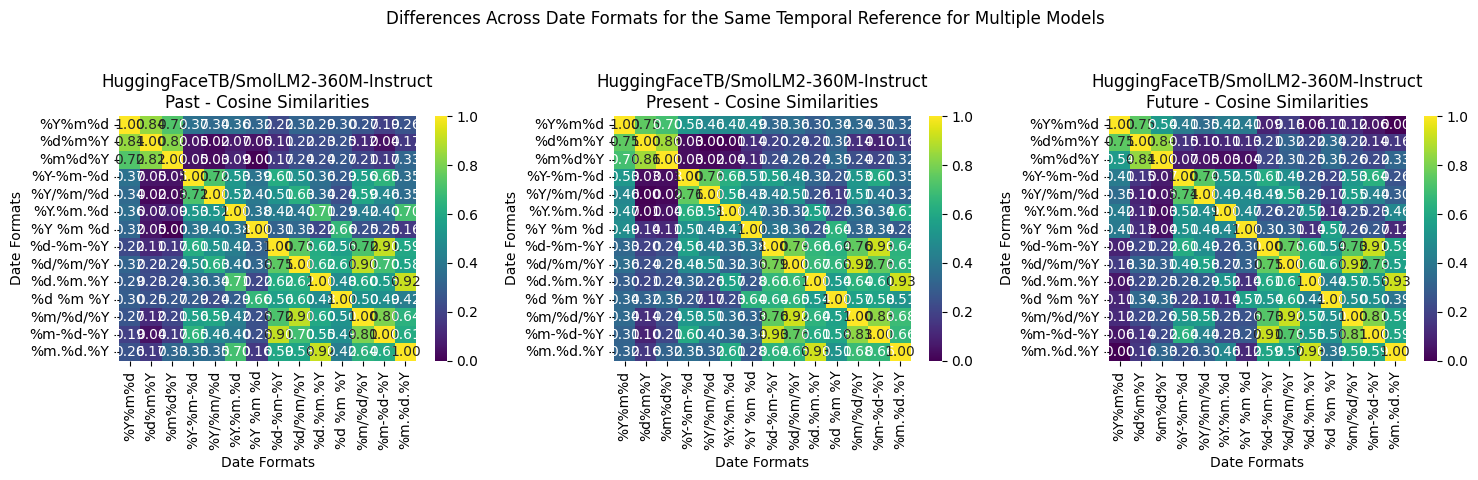

Using model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


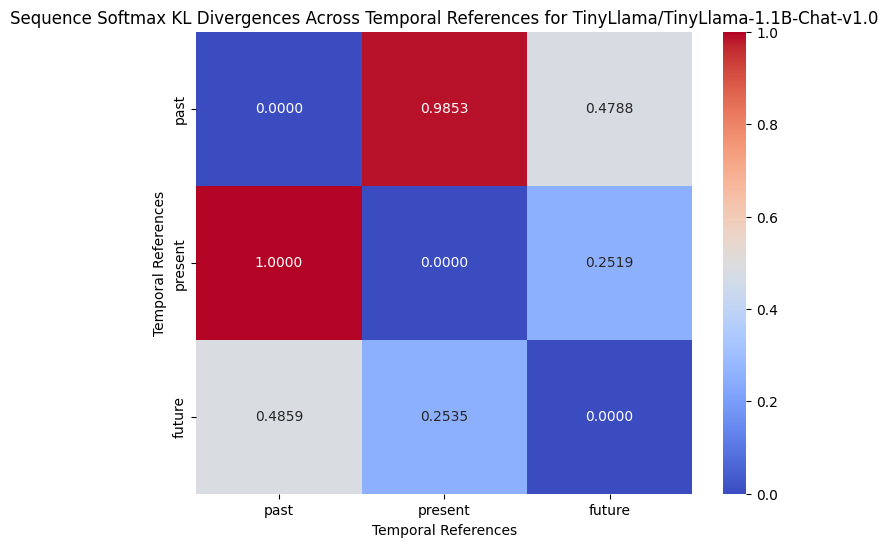

Analyzing model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Done analyzing model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


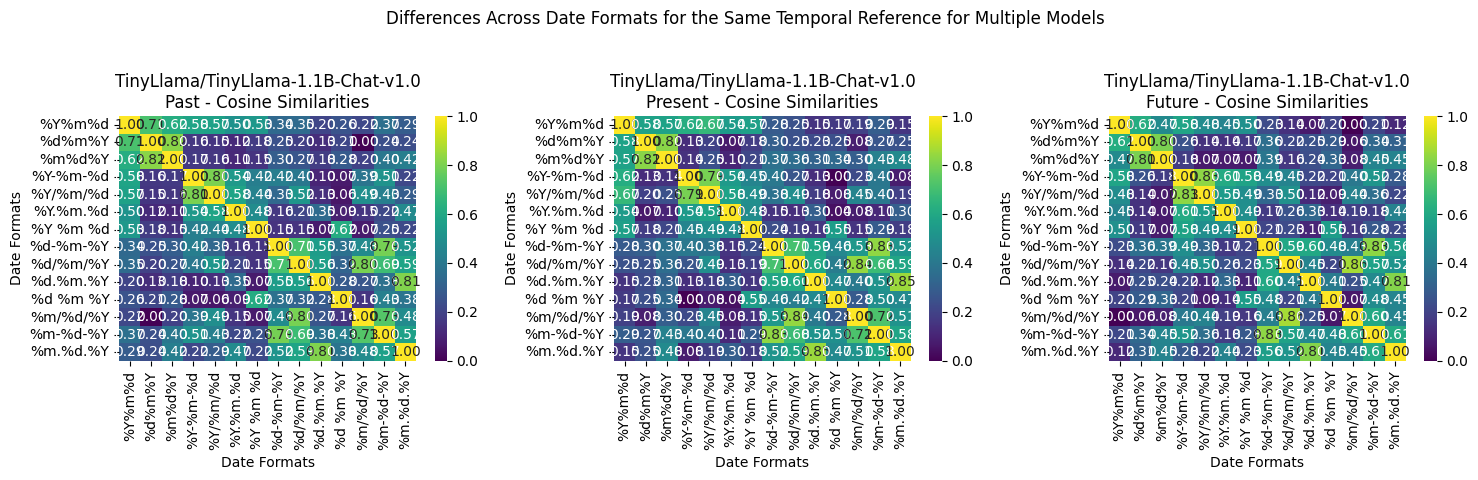

Using model: meta-llama/Llama-3.2-1B-Instruct


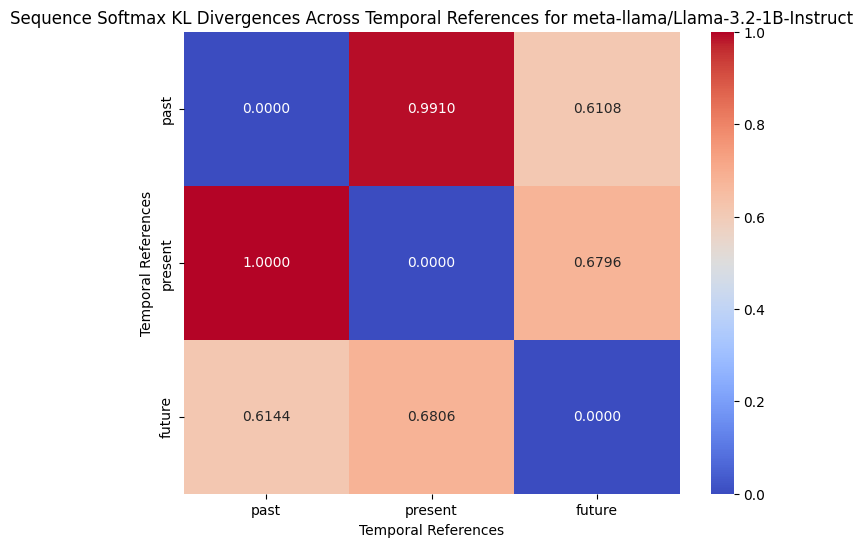

Analyzing model: meta-llama/Llama-3.2-1B-Instruct
Done analyzing model: meta-llama/Llama-3.2-1B-Instruct


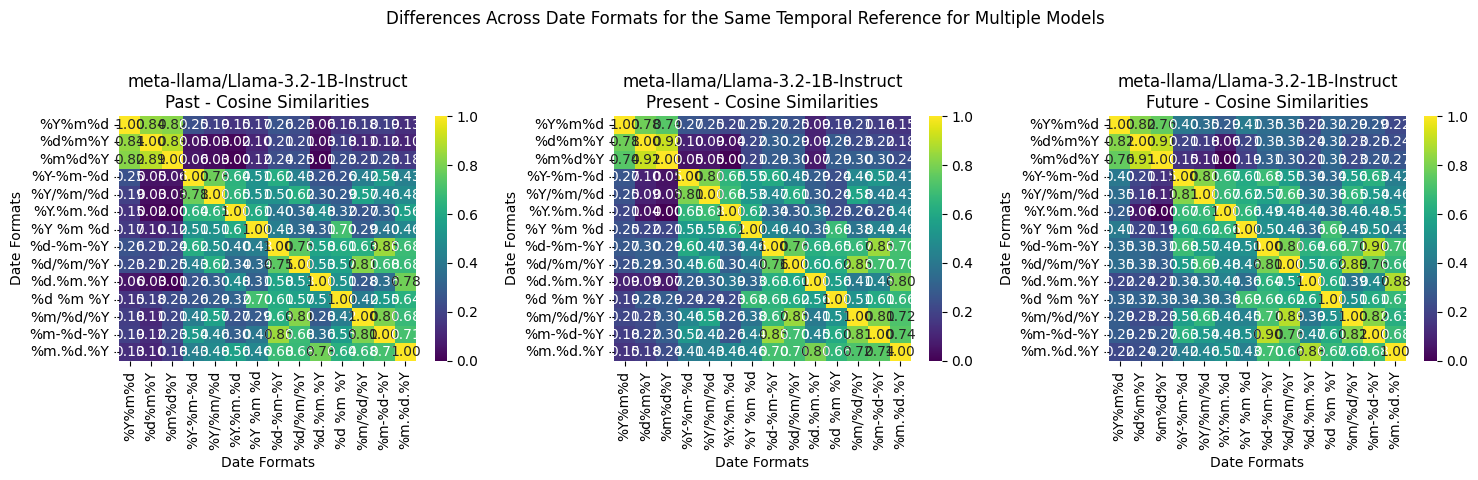

Using model: Qwen/Qwen2.5-0.5B-Instruct


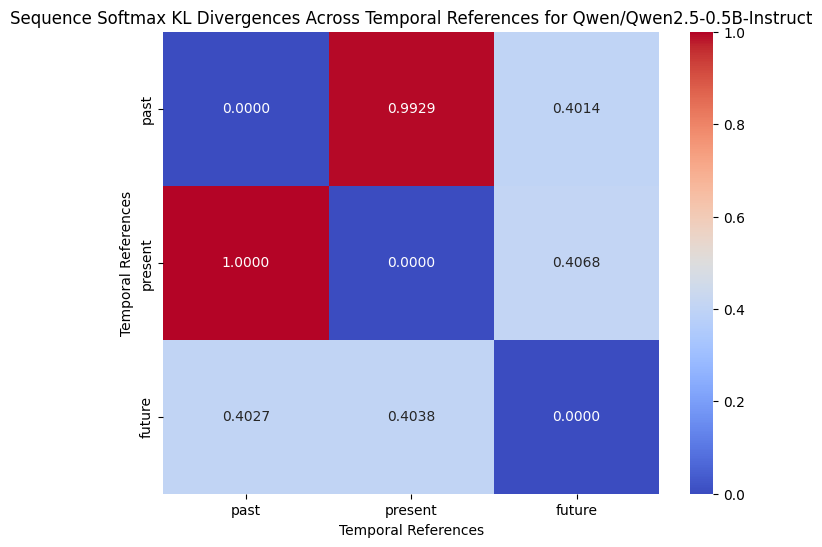

Analyzing model: Qwen/Qwen2.5-0.5B-Instruct
Done analyzing model: Qwen/Qwen2.5-0.5B-Instruct


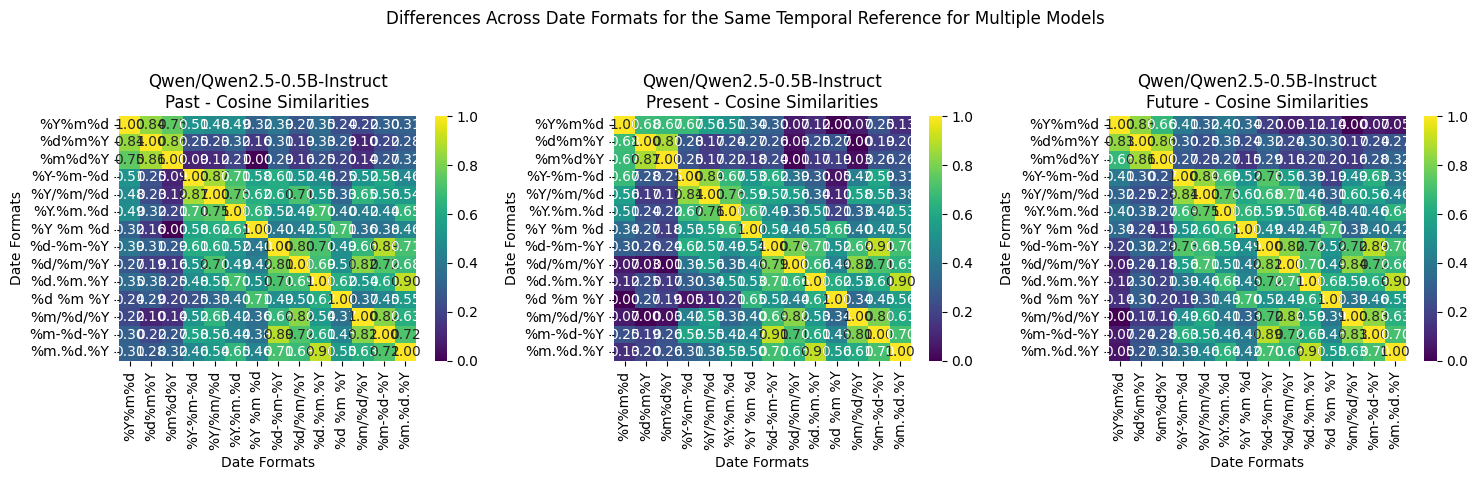

In [3]:
model_names = [
        "HuggingFaceTB/SmolLM2-360M-Instruct",
        "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
        "meta-llama/Llama-3.2-1B-Instruct",
        "Qwen/Qwen2.5-0.5B-Instruct",
        # "meta-llama/Llama-3.2-3B-Instruct",
        # "Qwen/Qwen2.5-1.5B-Instruct",
        # "Qwen/Qwen2.5-3B-Instruct",
        # "meta-llama/Llama-3.1-8B-Instruct",
        # "Qwen/Qwen2.5-7B-Instruct"
    ]
for model_name in model_names:
    main(model_name)
    main_embeddings([model_name])
